# Portfolio Optimization

A notebook that demonstrates end-to-end portfolio optimization using Yahoo Finance data. It covers data loading, preprocessing, mean-variance optimization, and evaluation with standard metrics and plots.

What you’ll see:
- Data fetch + caching to `data/`
- Long-only, fully-invested optimization
- Baseline vs. optimized portfolio comparison
- Metrics: annualized return, volatility, Sharpe, max drawdown
- Plots: equity curve and drawdown


### Quick Start

Install requirements and open this notebook.

```bash
pip install -r requirements.txt
```

Then run the cells top-to-bottom. Adjust symbols and period in the first code cell.


### Workflow

1. Configure `symbols` and `period` (e.g., `5y`).
2. Fetch and preprocess adjusted close prices via Yahoo (cached under `data/`).
3. Compute returns and summary stats.
4. Optimize weights (long-only, sum-to-1).
5. Compare to equal-weight baseline.
6. Visualize equity and drawdowns.
7. Save figures to `examples/figures/` and outputs to `examples/outputs/`.


### Notes on Data

- Source: Yahoo Finance via `yfinance`. Symbols may have missing days; simple forward/backward fills are applied.
- The service caches combined and processed CSVs under `data/processed/` to speed up reruns.
- If a symbol fails to load, it should be skipped with a warning; keep the rest of the flow running.


## Imports

In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
from __future__ import annotations

import os
import math
import pandas as pd
import numpy as np

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib
import matplotlib.pyplot as plt

from portfolio.data.yahoo_service import YahooFinanceService
from portfolio.optimizer.optimizer import SimplePortfolioOptimizer
from portfolio.performance.calculator import SimplePerformanceCalculator
from portfolio.performance.visualization import (
    plot_equity_curve,
    plot_drawdown_curve,
)

# Symbols and period
symbols = [
    "AAPL", "MSFT", "GOOGL", "AMZN",
    "META", "NVDA", "NFLX", "TSLA",
    "JPM", "JNJ", "PG", "HD",
    "DIS", "V", "MA", "UNH",
]
# Use longer history by default to stabilize risk estimates
period = "10y"

# Output paths
FIG_DIR = os.path.join("examples", "figures")
OUT_DIR = os.path.join("examples", "outputs")
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(OUT_DIR, exist_ok=True)

plt.style.use("seaborn-v0_8-whitegrid")
print(f"Symbols: {symbols}, Period: {period}")


Symbols: ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'NVDA', 'NFLX', 'TSLA', 'JPM', 'JNJ', 'PG', 'HD', 'DIS', 'V', 'MA', 'UNH'], Period: 10y


## Data Fetch

Pull adjusted close prices from Yahoo and cache combined/processed CSVs under `data/`. Simple `ffill`/`bfill` handles gaps; if a symbol fails, the rest proceed.


In [3]:
# Data fetch and quick QA
service = YahooFinanceService(use_offline_data=True, offline_data_dir="data")

# Show available offline cache (raw/processed/combined)
available = service.list_available_offline_data()
print("Offline data files:", {k: len(v) for k, v in available.items()})

# Consolidated adjusted close prices for selected symbols
prices = service.fetch_price_data(symbols, period)

# If the combined cache doesn't include all symbols, rebuild from per-symbol offline data
if prices.shape[1] < len(symbols):
    cols = []
    for s in symbols:
        try:
            df = service.fetch_historical_data(s, period)
            if not df.empty and "Adj Close" in df:
                cols.append(df["Adj Close"].rename(s))
        except Exception as e:
            print(f"Missing or failed for {s}: {e}")
    if cols:
        rebuilt = pd.concat(cols, axis=1).dropna()
        missing = [s for s in symbols if s not in rebuilt.columns]
        if missing:
            print("Symbols missing in rebuilt combined:", missing)
        prices = rebuilt

print("Prices shape:", prices.shape)
print(prices.head())
start_date = (prices.index.min()).strftime("%Y-%m-%d")
end_date = (prices.index.max()).strftime("%Y-%m-%d")
print("Backtest window:", start_date, "to", end_date)

# Per-symbol pipeline and quality report preview
pipeline = service.fetch_and_process_data(symbols, period)

rows = []
for sym, res in pipeline.items():
    if res.get("success"):
        q = res.get("quality_report", {})
        rows.append({
            "symbol": sym,
            "rows": q.get("data_summary", {}).get("total_rows"),
            "completeness": q.get("quality_metrics", {}).get("completeness"),
            "vol_annualized": q.get("quality_metrics", {}).get("volatility_annualized"),
        })
summary = pd.DataFrame(rows).set_index("symbol").sort_index()
print(summary.to_string())

2025-09-24 16:49:49,619 - portfolio.data.yahoo_service - INFO - Initialized YahooFinanceService
2025-09-24 16:49:49,681 - portfolio.data.yahoo_service - INFO - Fetching online price data for 16 symbols


Offline data files: {'raw': 43, 'processed': 44, 'combined': 2}


[*********************100%***********************]  16 of 16 completed
2025-09-24 16:49:53,885 - portfolio.data.yahoo_service - INFO - Saved combined price data to data\processed\combined_10y_prices.csv
2025-09-24 16:49:53,885 - portfolio.data.yahoo_service - INFO - Fetched price data for 16 symbols
2025-09-24 16:49:53,892 - portfolio.data.yahoo_service - INFO - Processing data for AAPL
2025-09-24 16:49:53,917 - portfolio.data.yahoo_service - INFO - Loaded offline data for AAPL (10y): 2514 rows
2025-09-24 16:49:53,926 - portfolio.data.yahoo_service - INFO - Cleaned data: 2514 -> 2514 rows
2025-09-24 16:49:53,960 - portfolio.data.yahoo_service - INFO - Generated quality report for AAPL
2025-09-24 16:49:53,961 - portfolio.data.yahoo_service - INFO - Successfully processed data for AAPL
2025-09-24 16:49:53,961 - portfolio.data.yahoo_service - INFO - Processing data for MSFT
2025-09-24 16:49:53,982 - portfolio.data.yahoo_service - INFO - Loaded offline data for MSFT (10y): 2514 rows
2025-0

Prices shape: (2514, 16)
Ticker           AAPL       AMZN        DIS      GOOGL         HD        JNJ  \
Date                                                                           
2015-09-25  25.778261  26.212500  92.482872  31.788254  92.186134  68.916847   
2015-09-28  25.268139  25.202999  90.813942  30.998699  90.101395  69.197067   
2015-09-29  24.508572  24.803499  91.671440  30.917261  89.161674  70.461754   
2015-09-30  24.787224  25.594500  94.234779  31.699863  91.199051  70.696564   
2015-10-01  24.625425  26.035999  94.668152  31.880119  92.415131  70.560226   

Ticker            JPM         MA       META       MSFT        NFLX      NVDA  \
Date                                                                           
2015-09-25  46.792572  85.940308  92.201599  38.288261  102.239998  0.573762   
2015-09-28  45.658344  83.163460  88.663422  37.721870   99.470001  0.566228   
2015-09-29  45.551769  83.549400  86.138977  37.852573   98.349998  0.576192   
2015-09-30  46

2025-09-24 16:49:54,076 - portfolio.data.yahoo_service - INFO - Successfully processed data for GOOGL
2025-09-24 16:49:54,077 - portfolio.data.yahoo_service - INFO - Processing data for AMZN
2025-09-24 16:49:54,097 - portfolio.data.yahoo_service - INFO - Loaded offline data for AMZN (10y): 2514 rows
2025-09-24 16:49:54,100 - portfolio.data.yahoo_service - INFO - Cleaned data: 2514 -> 2514 rows
2025-09-24 16:49:54,130 - portfolio.data.yahoo_service - INFO - Generated quality report for AMZN
2025-09-24 16:49:54,131 - portfolio.data.yahoo_service - INFO - Successfully processed data for AMZN
2025-09-24 16:49:54,132 - portfolio.data.yahoo_service - INFO - Processing data for META
2025-09-24 16:49:54,153 - portfolio.data.yahoo_service - INFO - Loaded offline data for META (10y): 2514 rows
2025-09-24 16:49:54,160 - portfolio.data.yahoo_service - INFO - Cleaned data: 2514 -> 2514 rows
2025-09-24 16:49:54,188 - portfolio.data.yahoo_service - INFO - Generated quality report for META
2025-09-24 

        rows  completeness  vol_annualized
symbol                                    
AAPL    2514           1.0        0.292019
AMZN    2514           1.0        0.327704
DIS     2514           1.0        0.284515
GOOGL   2514           1.0        0.286909
HD      2514           1.0        0.245212
JNJ     2514           1.0        0.183756
JPM     2514           1.0        0.276200
MA      2514           1.0        0.268844
META    2514           1.0        0.383966
MSFT    2514           1.0        0.269501
NFLX    2514           1.0        0.422279
NVDA    2514           1.0        0.499019
PG      2514           1.0        0.187211
TSLA    2514           1.0        0.592215
UNH     2514           1.0        0.291295
V       2514           1.0        0.245639


## Scenario toggles

- Options: risk models ['sample', 'ledoit_wolf', 'oas']
- Defaults: cap=0.18, entropy=0.03

In [4]:
mvo_risk_model = "ledoit_wolf"
mvo_weight_cap = 0.18
mvo_entropy_penalty = 0.03
print({
    "risk_model": mvo_risk_model,
    "weight_cap": mvo_weight_cap,
    "entropy_penalty": mvo_entropy_penalty,
})

{'risk_model': 'ledoit_wolf', 'weight_cap': 0.18, 'entropy_penalty': 0.03}


## Returns & Correlations

Compute daily percent returns with `pct_change().dropna()`. Preview summary stats and the correlation matrix to sanity‑check inputs.


### Data sanity checks
- We use adjusted close prices; gaps are handled with forward/backward fill.
- A quick correlations preview helps spot anomalous symbols.
- Returns shape and summary stats are printed to confirm the input matrix integrity.


In [5]:
# Returns computation
asset_returns = prices.pct_change().dropna()
print("Returns shape:", asset_returns.shape)
print(asset_returns.describe().T[["mean", "std"]])

corr = asset_returns.corr()
print("Pairwise correlations (head):")
print(corr.head())

Returns shape: (2513, 16)
            mean       std
Ticker                    
AAPL    0.001077  0.018400
AMZN    0.001060  0.020641
DIS     0.000241  0.017927
GOOGL   0.000980  0.018069
HD      0.000714  0.015450
JNJ     0.000442  0.011569
JPM     0.000908  0.017393
MA      0.000895  0.016939
META    0.001135  0.024187
MSFT    0.001175  0.016980
NFLX    0.001343  0.026604
NVDA    0.002773  0.031442
PG      0.000474  0.011785
TSLA    0.001988  0.037314
UNH     0.000674  0.018321
V       0.000771  0.015476
Pairwise correlations (head):
Ticker      AAPL      AMZN       DIS     GOOGL        HD       JNJ       JPM  \
Ticker                                                                         
AAPL    1.000000  0.576512  0.426937  0.612246  0.500504  0.308947  0.422386   
AMZN    0.576512  1.000000  0.389482  0.651249  0.417038  0.175825  0.313843   
DIS     0.426937  0.389482  1.000000  0.421068  0.461085  0.270564  0.546653   
GOOGL   0.612246  0.651249  0.421068  1.000000  0.450133  

## Mean–Variance Optimization

Long‑only, fully invested. Tunables: `weight_cap` (diversification) and `entropy_penalty` (spread). Outputs: weights and MVO metrics.


In [6]:
# Mean-Variance optimization (baseline - capped and diversified)
opt = SimplePortfolioOptimizer()

mvo = opt.mean_variance_optimize(
    asset_returns,
    risk_model=mvo_risk_model,
    weight_cap=mvo_weight_cap,
    entropy_penalty=mvo_entropy_penalty,
)
weights = pd.Series(mvo["weights"]).sort_values(ascending=False)
print("Weights:\n", weights)
print({k: round(v, 4) for k, v in mvo.items() if k != "weights"})

# Effective Number of Holdings (ENH)
_eps = 1e-12
wpos = weights[weights > 0]
enh = float(np.exp(-np.sum(wpos * np.log(wpos + _eps)))) if not wpos.empty else 0.0
print(f"ENH: {enh:.2f}")

portfolio_returns = (asset_returns * weights).sum(axis=1)
print("Portfolio returns length:", len(portfolio_returns))


2025-09-24 16:49:54,959 - portfolio.config - INFO - Loaded configuration from config.yaml
2025-09-24 16:49:54,959 - portfolio.optimizer.optimizer - INFO - Initialized SimplePortfolioOptimizer


Weights:
 NVDA     0.180000
TSLA     0.180000
NFLX     0.180000
MSFT     0.153638
META     0.070251
AAPL     0.069329
AMZN     0.045419
JPM      0.037534
GOOGL    0.032388
MA       0.022970
V        0.009566
UNH      0.007614
HD       0.007269
PG       0.002133
JNJ      0.001765
DIS      0.000124
dtype: float64
{'expected_return': 0.4001, 'expected_volatility': 0.2981, 'sharpe_ratio': 1.2751}
ENH: 8.93
Portfolio returns length: 2513


## Returns-Maximizing MVO (concentrated)

Use the same prices but tilt for maximum expected return:
- risk_model = `sample` (less shrinkage)
- weight_cap = `None` (allow concentration)
- entropy_penalty = `0.0` (no diversification pressure)
- target_return ≈ 0.99 × max annualized mean

Note: Expect concentrated allocations; use for a high-return baseline comparison.


In [7]:
# Concentrated, return-maximizing MVO
opt_conc = SimplePortfolioOptimizer()

# Ensure performance calculator is available in this cell
from portfolio.performance.calculator import SimplePerformanceCalculator
perf = SimplePerformanceCalculator()

# Use shorter window for mean estimation from existing prices
a_returns = prices.pct_change().dropna()
annual_means = a_returns.tail(252).mean() * opt_conc.trading_days_per_year  # 1y momentum
trg = 0.99 * float(annual_means.max())

mvo_conc = opt_conc.mean_variance_optimize(
    returns=a_returns,
    target_return=trg,
    weight_cap=None,
    risk_model="sample",
    entropy_penalty=0.0,
)

w_conc = pd.Series(mvo_conc["weights"]).sort_values(ascending=False)
print("Concentrated weights:\n", w_conc.head(10))
print({k: round(v, 4) for k, v in mvo_conc.items() if k != "weights"})

returns_conc = (a_returns * w_conc).sum(axis=1)
perf_conc = perf.calculate_metrics(returns_conc)
print("Concentrated realized metrics:", {k: (round(v, 4) if isinstance(v, (int, float)) else v) for k, v in perf_conc.items()})


2025-09-24 16:49:55,038 - portfolio.optimizer.optimizer - INFO - Initialized SimplePortfolioOptimizer
2025-09-24 16:49:55,083 - portfolio.optimizer.optimizer - WARNING - Optimization status: infeasible


Concentrated weights:
 AAPL     0.0625
AMZN     0.0625
DIS      0.0625
GOOGL    0.0625
HD       0.0625
JNJ      0.0625
JPM      0.0625
MA       0.0625
META     0.0625
MSFT     0.0625
dtype: float64
{'expected_return': 0.2622, 'expected_volatility': 0.2113, 'sharpe_ratio': 1.1462}
Concentrated realized metrics: {'total_return': np.float64(9.9223), 'annual_return': np.float64(0.2709), 'annual_volatility': np.float64(0.2113), 'sharpe_ratio': np.float64(1.1873), 'max_drawdown': np.float64(-0.3321), 'best_day': np.float64(0.1037), 'worst_day': np.float64(-0.1268), 'win_rate': np.float64(0.5742)}


## Top weights

In [8]:
print(weights.to_string())

NVDA     0.180000
TSLA     0.180000
NFLX     0.180000
MSFT     0.153638
META     0.070251
AAPL     0.069329
AMZN     0.045419
JPM      0.037534
GOOGL    0.032388
MA       0.022970
V        0.009566
UNH      0.007614
HD       0.007269
PG       0.002133
JNJ      0.001765
DIS      0.000124


## Performance metrics

In [9]:
perf = SimplePerformanceCalculator()

# SPY benchmark
try:
    spy = service.fetch_price_data(["SPY"], period)
    benchmark_returns = spy.pct_change().dropna().iloc[:, 0]
except Exception:
    benchmark_returns = None

metrics = perf.calculate_metrics(portfolio_returns, benchmark_returns)
print({k: (round(v, 4) if isinstance(v, (int, float)) else v) for k, v in metrics.items()})


2025-09-24 16:49:55,165 - portfolio.data.yahoo_service - INFO - Fetching online price data for 1 symbols


[*********************100%***********************]  1 of 1 completed
2025-09-24 16:49:55,681 - portfolio.data.yahoo_service - INFO - Saved combined price data to data\processed\combined_10y_prices.csv
2025-09-24 16:49:55,682 - portfolio.data.yahoo_service - INFO - Fetched price data for 1 symbols


{'total_return': np.float64(33.4474), 'annual_return': np.float64(0.4261), 'annual_volatility': np.float64(0.2992), 'sharpe_ratio': np.float64(1.357), 'max_drawdown': np.float64(-0.4888), 'best_day': np.float64(0.1416), 'worst_day': np.float64(-0.1473), 'win_rate': np.float64(0.5619), 'beta': np.float64(1.3585), 'alpha': np.float64(0.2284), 'information_ratio': np.float64(1.3297)}


## Plots: equity curve and drawdown (adds equal-weight baseline)

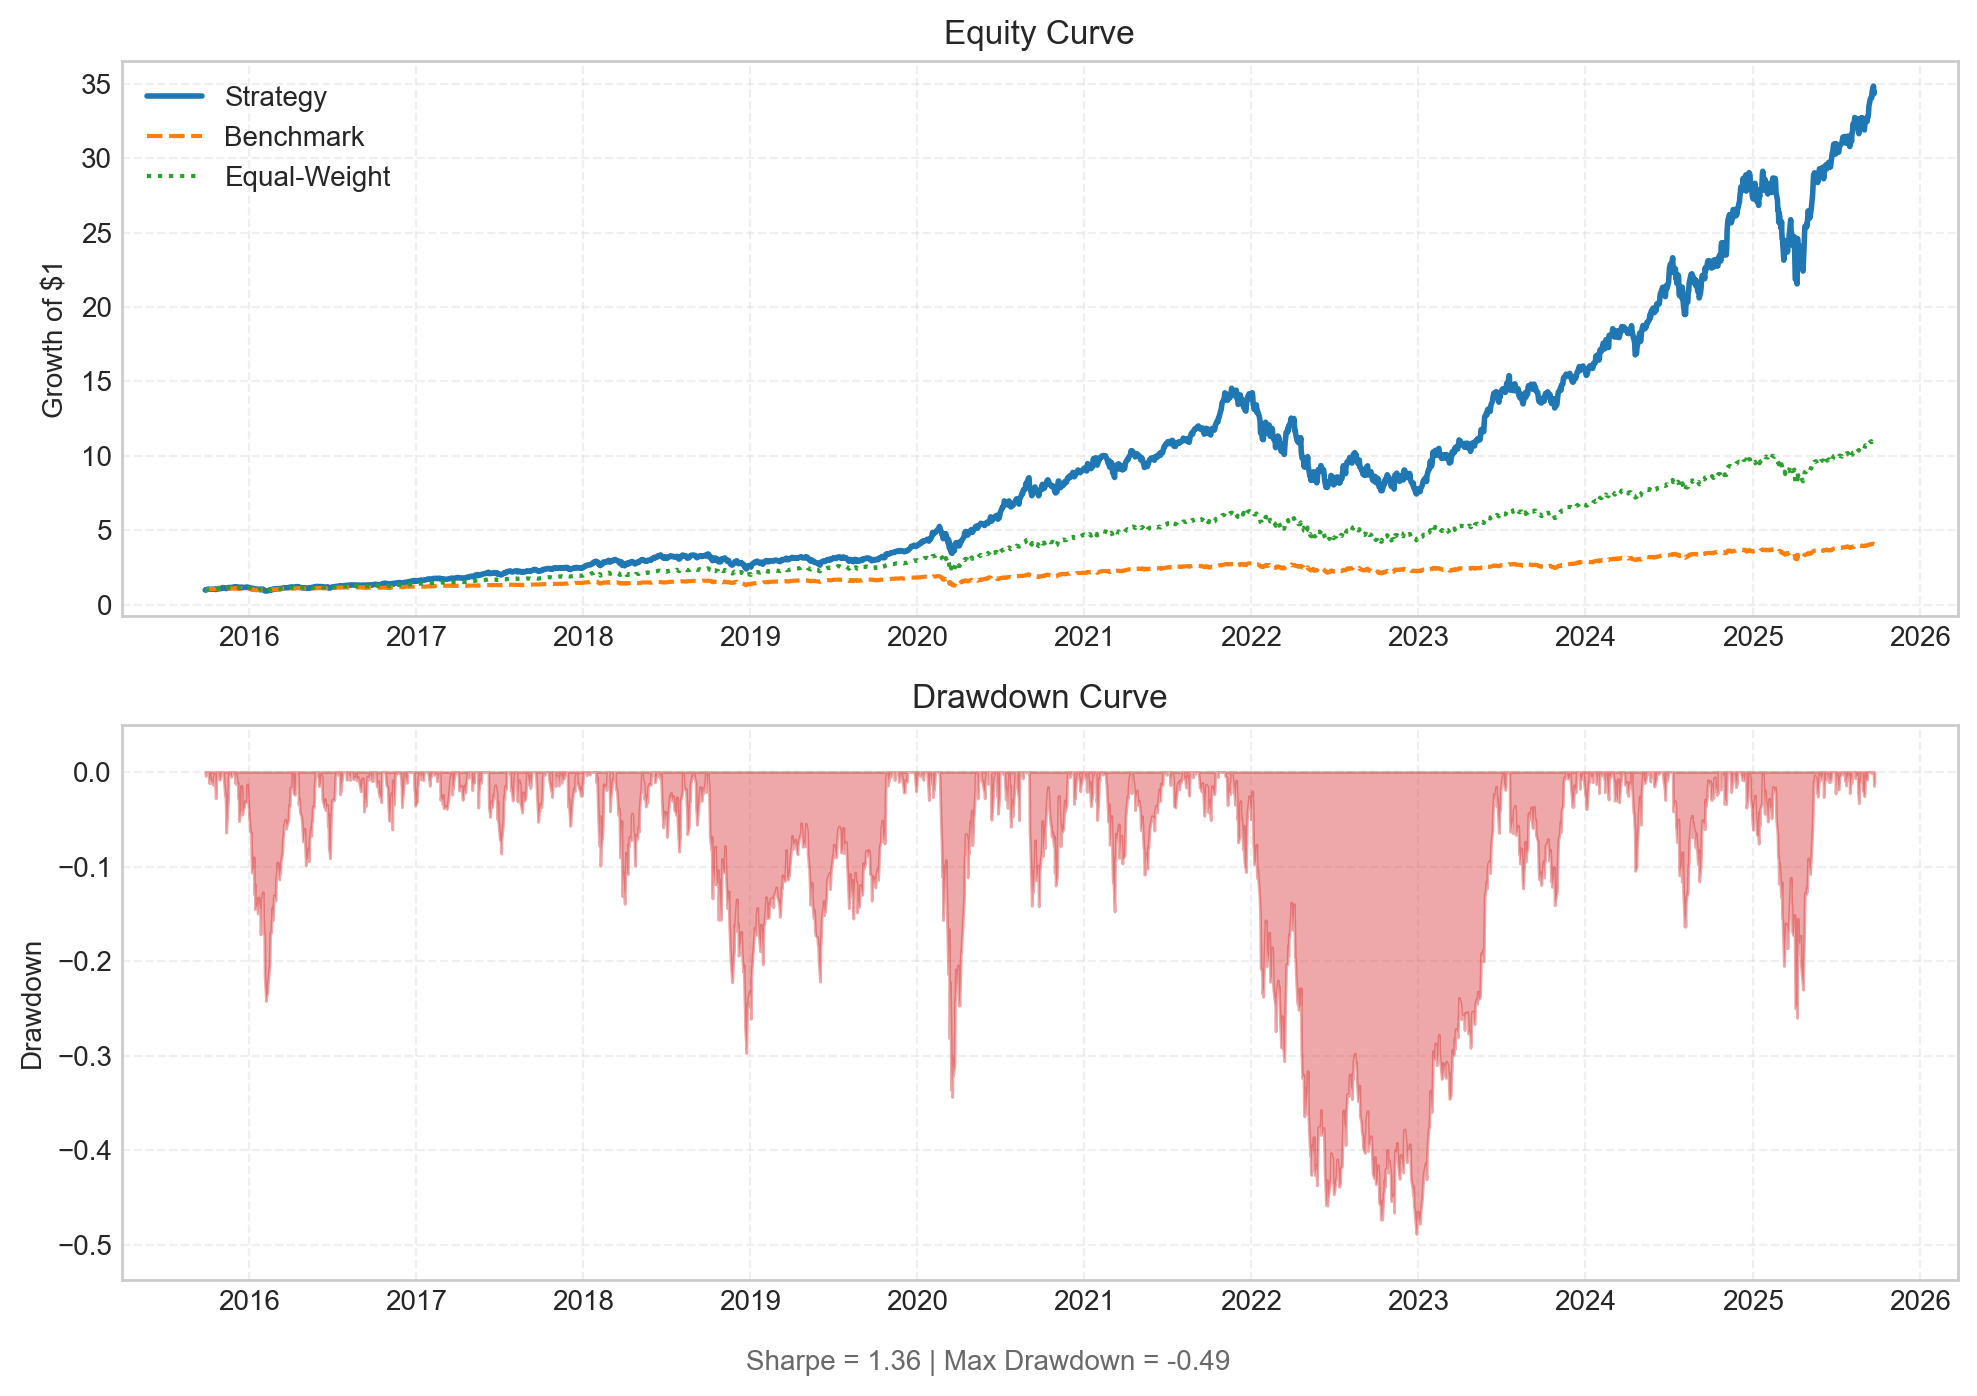

In [10]:
fig, axes = plt.subplots(2, 1, figsize=(10, 7))
plot_equity_curve(portfolio_returns, benchmark_returns, ax=axes[0])
# Add equal-weight curve for comparison
try:
    from portfolio.performance.visualization import prepare_equity_curve
    ew_weights = pd.Series(1.0/asset_returns.shape[1], index=asset_returns.columns)
    ew_returns = (asset_returns * ew_weights).sum(axis=1)
    ew_curve = prepare_equity_curve(ew_returns)
    axes[0].plot(ew_curve.index, ew_curve.values, label="Equal-Weight", linestyle=":")
    axes[0].legend(loc="best")
except Exception:
    pass

plot_drawdown_curve(portfolio_returns, ax=axes[1])

# Caption under the figure with Sharpe and Max Drawdown
try:
    sharpe_val = float(metrics.get("sharpe_ratio", 0.0))
    mdd_val = float(metrics.get("max_drawdown", 0.0))
    fig.text(0.5, 0.01, f"Sharpe = {sharpe_val:.2f} | Max Drawdown = {mdd_val:.2f}",
             ha="center", va="bottom", fontsize=10, color="dimgray")
except Exception:
    pass

plt.tight_layout(rect=[0, 0.03, 1, 1])
from IPython.display import display
display(fig)

# Save figure (overwrite existing path)
fig.savefig(os.path.join(FIG_DIR, "equity_and_drawdown.png"), dpi=150)


## Efficient Frontier (Preview)

Scatter colored by Sharpe; saved to `examples/figures/efficient_frontier.png`.


[*********************100%***********************]  16 of 16 completed


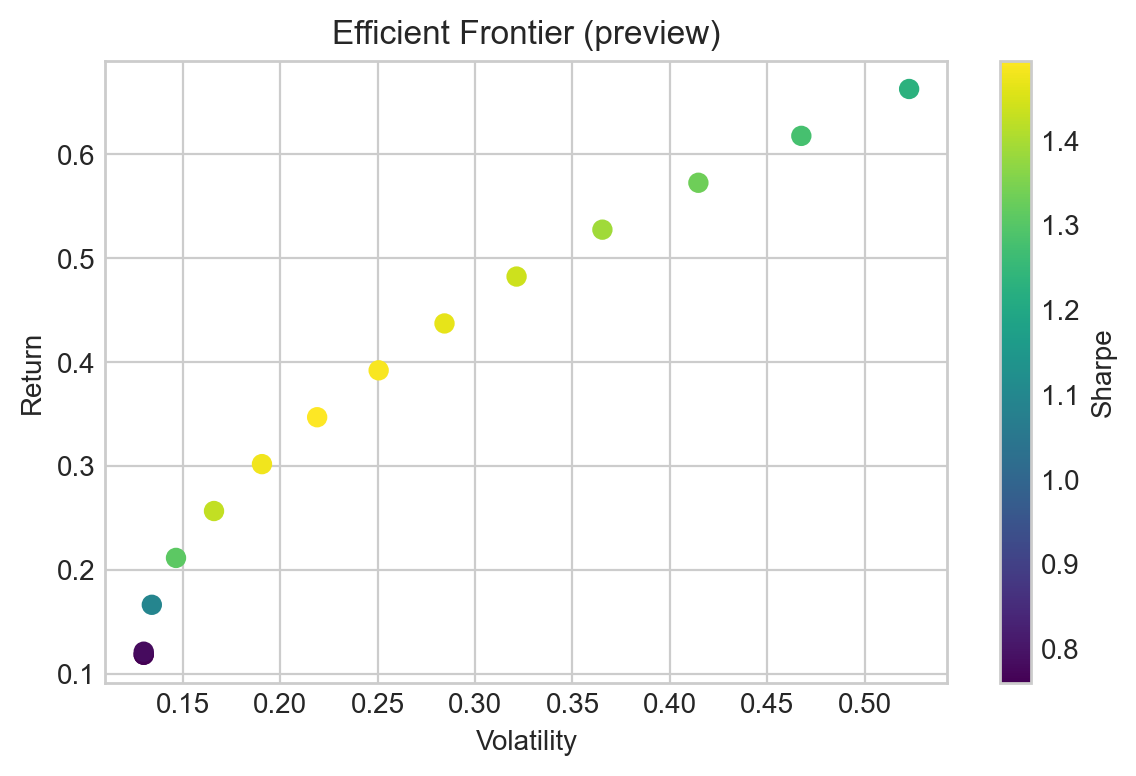

In [11]:
# Efficient frontier preview
frontier = opt.get_efficient_frontier(symbols, n_points=15)

if frontier:
    fr = pd.DataFrame(frontier)
    fig, ax = plt.subplots(figsize=(6,4))
    sc = ax.scatter(fr["volatility"], fr["return"], c=fr["sharpe_ratio"], cmap="viridis", s=40)
    ax.set_xlabel("Volatility")
    ax.set_ylabel("Return")
    ax.set_title("Efficient Frontier (preview)")
    cbar = plt.colorbar(sc, ax=ax, label="Sharpe")
    plt.tight_layout()
    from IPython.display import display
    display(fig)
    fig.savefig(os.path.join(FIG_DIR, "efficient_frontier.png"), dpi=150)
else:
    print("Efficient frontier not available (insufficient data).")


### Efficient frontier takeaways
- Each point solves a minimum-variance problem at a target return under long-only constraints.
- The color shading (Sharpe) highlights the risk-efficient region.
- Use this as a qualitative check; final allocations come from the constrained MVO step.


## Parameter Sweep

Explore how risk model, weight cap, and entropy affect expected Sharpe/vol/return. Notes:
- Shrinkage covariances (Ledoit–Wolf, OAS) often top Sharpe.
- Small entropy (0.01–0.05) can improve diversification with modest Sharpe impact.
- Use this grid to justify demo defaults (cap=0.18, entropy=0.03) and trade‑offs.


In [12]:
# Simple tuning grid (risk model, weight cap, entropy)
from itertools import product

risk_models = ["sample", "ledoit_wolf", "oas"]
weight_caps = [None, 0.35, 0.25, 0.18, 0.15]
entropy_penalties = [0.0, 0.01, 0.03, 0.05]

records = []
for rm, cap, ent in product(risk_models, weight_caps, entropy_penalties):
    res = opt.mean_variance_optimize(
        asset_returns,
        risk_model=rm,
        weight_cap=cap,
        entropy_penalty=ent,
    )
    records.append({
        "risk_model": rm,
        "weight_cap": cap,
        "weight_cap_display": ("unconstrained" if cap is None else cap),
        "entropy": ent,
        "sharpe": float(res.get("sharpe_ratio", 0)),
        "vol": float(res.get("expected_volatility", 0)),
        "ret": float(res.get("expected_return", 0)),
    })

summary = pd.DataFrame(records)
view = summary.sort_values(by=["sharpe", "ret"], ascending=[False, False])[
    ["risk_model", "weight_cap_display", "entropy", "sharpe", "vol", "ret"]
].rename(columns={"weight_cap_display": "weight_cap"})

# Helpful filtered views
constrained = view[view["weight_cap"] != "unconstrained"]
focus_018 = view.query("weight_cap == 0.18")

with pd.option_context('display.float_format', lambda x: f"{x:.6f}"):
    print("Top overall (in-sample):\n" + view.head(12).to_string(index=False))
    if not constrained.empty:
        print("\nTop constrained (cap != unconstrained):\n" + constrained.head(12).to_string(index=False))
    if not focus_018.empty:
        print("\nFocus on cap = 0.18:\n" + focus_018.sort_values(["sharpe","ret"], ascending=[False, False]).to_string(index=False))

Top overall (in-sample):
 risk_model    weight_cap  entropy   sharpe      vol      ret
ledoit_wolf unconstrained 0.050000 1.388018 0.463967 0.663994
        oas unconstrained 0.050000 1.385311 0.464798 0.663890
     sample unconstrained 0.050000 1.383960 0.465205 0.663825
ledoit_wolf unconstrained 0.030000 1.376221 0.485781 0.688542
        oas unconstrained 0.030000 1.373681 0.486666 0.688523
     sample unconstrained 0.030000 1.372402 0.487106 0.688505
ledoit_wolf unconstrained 0.010000 1.363793 0.497606 0.698632
ledoit_wolf unconstrained 0.000000 1.363591 0.497780 0.698769
        oas unconstrained 0.010000 1.361360 0.498495 0.698631
        oas unconstrained 0.000000 1.361159 0.498670 0.698769
     sample unconstrained 0.010000 1.360117 0.498949 0.698630
     sample unconstrained 0.000000 1.359915 0.499126 0.698769

Top constrained (cap != unconstrained):
 risk_model weight_cap  entropy   sharpe      vol      ret
ledoit_wolf   0.350000 0.050000 1.304435 0.366440 0.497998
        oa

## Save Key Artifacts

Saves: `weights_mvo.csv`, `metrics_mvo.csv`, and optionally `efficient_frontier.csv` to `examples/outputs/`.


In [13]:
# Weights and metrics
weights.to_csv(os.path.join(OUT_DIR, "weights_mvo.csv"))
pd.Series(metrics).to_csv(os.path.join(OUT_DIR, "metrics_mvo.csv"))

# Frontier points (if available)
if 'frontier' in globals() and frontier:
    pd.DataFrame(frontier).to_csv(os.path.join(OUT_DIR, "efficient_frontier.csv"), index=False)

print("Artifacts saved to:", OUT_DIR)

Artifacts saved to: examples\outputs


## Other Methods

### Alternative allocations (CVaR, Black–Litterman)
- CVaR tends to reduce tail risk and volatility; Sharpe can improve if the market regime penalizes variance‑heavy names.
- Black–Litterman (neutral views here) leans toward market‑like risk allocation; useful as a conservative reference.

In [14]:
cvar = opt.cvar_optimize(asset_returns, alpha=0.05)
bl = opt.black_litterman_optimize(asset_returns)

summary = pd.DataFrame([
    {"method": "MVO", **{k: v for k, v in mvo.items() if k != "weights"}},
    {"method": "CVaR", **{k: v for k, v in cvar.items() if k != "weights"}},
    {"method": "BL", **{k: v for k, v in bl.items() if k != "weights"}},
])
print(summary[["method", "expected_return", "expected_volatility", "sharpe_ratio"]])

  method  expected_return  expected_volatility  sharpe_ratio
0    MVO         0.400065             0.298063      1.275114
1   CVaR         0.277300             0.191026      1.346936
2     BL         0.430738             0.318439      1.289849


### Realized metrics for CVaR and BL

In [15]:
w_cvar = pd.Series(cvar["weights"])
w_bl   = pd.Series(bl["weights"])

r_cvar = (asset_returns * w_cvar).sum(axis=1)
r_bl   = (asset_returns * w_bl).sum(axis=1)

m_cvar = perf.calculate_metrics(r_cvar, benchmark_returns)
m_bl   = perf.calculate_metrics(r_bl, benchmark_returns)
print("CVaR realized:", {k: (round(v,4) if isinstance(v,(int,float)) else v) for k,v in m_cvar.items()})
print("BL realized:",   {k: (round(v,4) if isinstance(v,(int,float)) else v) for k,v in m_bl.items()})

CVaR realized: {'total_return': np.float64(12.2228), 'annual_return': np.float64(0.2955), 'annual_volatility': np.float64(0.191), 'sharpe_ratio': np.float64(1.4423), 'max_drawdown': np.float64(-0.3206), 'best_day': np.float64(0.0994), 'worst_day': np.float64(-0.1059), 'win_rate': np.float64(0.5682), 'beta': np.float64(0.9333), 'alpha': np.float64(0.1535), 'information_ratio': np.float64(1.3311)}
BL realized: {'total_return': np.float64(42.9176), 'annual_return': np.float64(0.4612), 'annual_volatility': np.float64(0.3197), 'sharpe_ratio': np.float64(1.3803), 'max_drawdown': np.float64(-0.5108), 'best_day': np.float64(0.1535), 'worst_day': np.float64(-0.1518), 'win_rate': np.float64(0.5671), 'beta': np.float64(1.4382), 'alpha': np.float64(0.2532), 'information_ratio': np.float64(1.3546)}


### CVaR & BL overlay plot

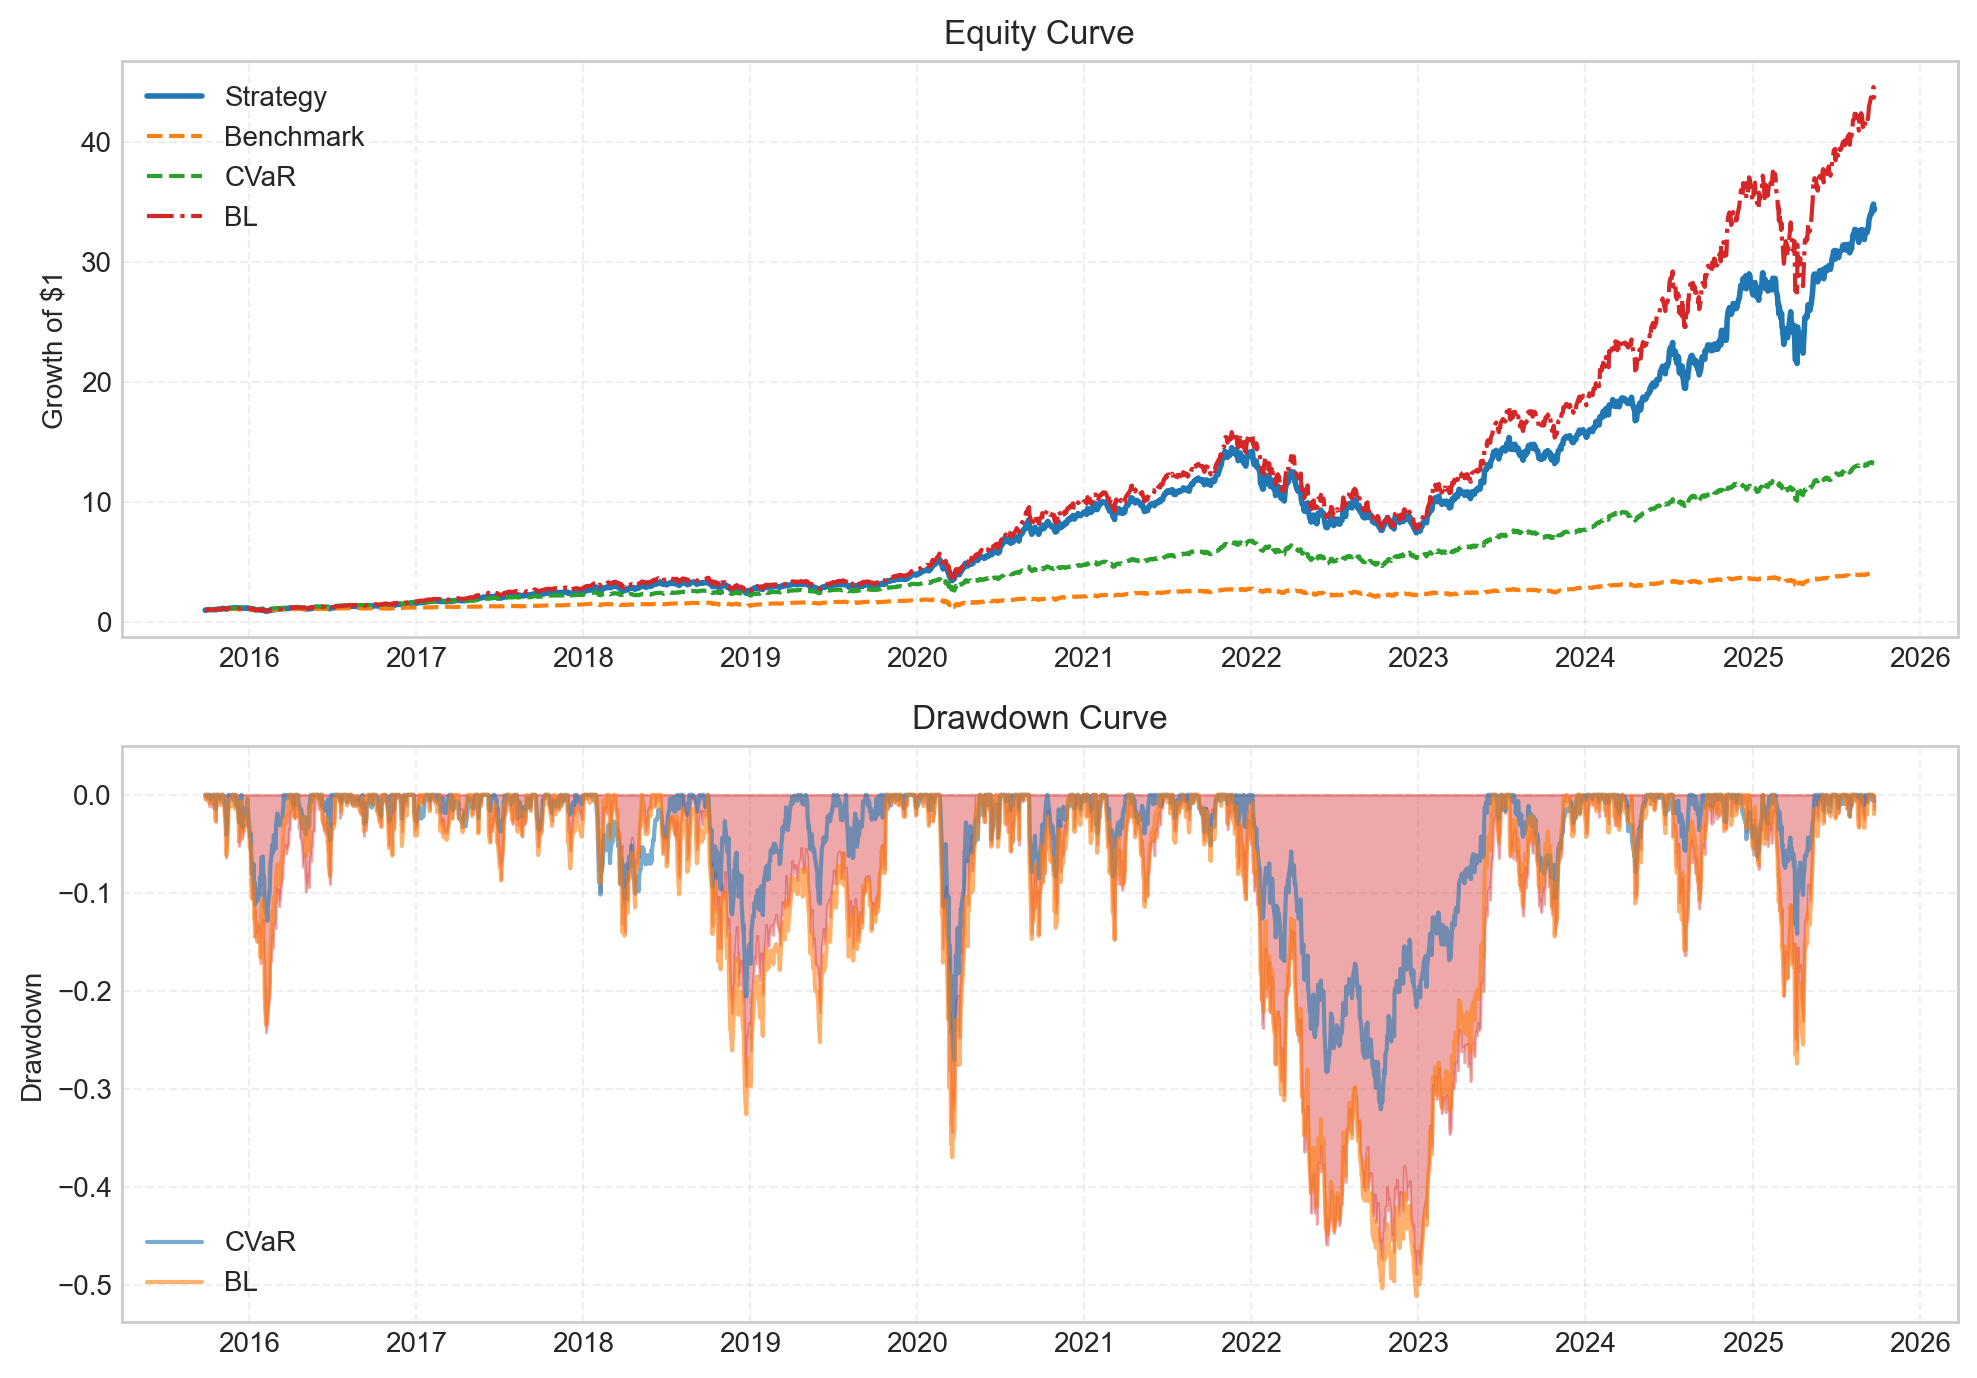

In [16]:
from IPython.display import display
from portfolio.performance.visualization import prepare_equity_curve, prepare_drawdown_curve

# Ensure realized return series exist
try:
    w_cvar = pd.Series(cvar["weights"])
    w_bl   = pd.Series(bl["weights"])
    r_cvar = (asset_returns * w_cvar).sum(axis=1)
    r_bl   = (asset_returns * w_bl).sum(axis=1)
except Exception as e:
    print("CVaR/BL returns not available:", e)

fig, axes = plt.subplots(2, 1, figsize=(10, 7))

# Equity curves
plot_equity_curve(portfolio_returns, benchmark_returns, ax=axes[0])
try:
    eq_cvar = prepare_equity_curve(r_cvar)
    eq_bl   = prepare_equity_curve(r_bl)
    axes[0].plot(eq_cvar.index, eq_cvar.values, label="CVaR", linestyle="--")
    axes[0].plot(eq_bl.index, eq_bl.values, label="BL", linestyle="-.")
    axes[0].legend(loc="best")
except Exception:
    pass

# Drawdowns
plot_drawdown_curve(portfolio_returns, ax=axes[1])
try:
    dd_cvar = prepare_drawdown_curve(r_cvar)
    dd_bl   = prepare_drawdown_curve(r_bl)
    axes[1].plot(dd_cvar.index, dd_cvar.values, label="CVaR", alpha=0.6)
    axes[1].plot(dd_bl.index, dd_bl.values, label="BL", alpha=0.6)
    axes[1].legend(loc="best")
except Exception:
    pass

plt.tight_layout()
display(fig)
fig.savefig(os.path.join(FIG_DIR, "cvar_bl_overlay.png"), dpi=150)
plt.close(fig)


## Full-data ML training (multi-symbol, long horizon)

This section trains the selected model across multiple symbols over a long historical period (e.g., 10y or max). Configure symbols, period, model, and GPU usage below.


In [25]:
# ML configuration for full portfolio training
ML_SYMBOLS = [
    "AAPL", "MSFT", "GOOGL", "AMZN", "META", "NVDA", "TSLA",
    "V", "MA", "JPM", "JNJ", "PG", "HD", "DIS", "NFLX", "ADBE",
]
ML_PERIOD = "10y"  # e.g., "5y", "10y", "max"
ML_MODEL = "xgb"   # "rf" or "xgb"
ML_DEVICE = "cuda" # "cuda" to use GPU if available, else "cpu"
ML_MIN_SAMPLES = 252  # skip symbols with less data

In [ ]:
# Multi-symbol training over long history (per-symbol metrics)
import time
import logging
import pandas as pd
from portfolio.data.yahoo_service import YahooFinanceService
from portfolio.ml import RandomForestPredictor, XGBoostPredictor

logging.basicConfig(level=logging.INFO)
service = YahooFinanceService(use_offline_data=True, offline_data_dir="data")

results = []
for sym in ML_SYMBOLS:
    try:
        data = service.fetch_historical_data(sym, period=ML_PERIOD)
        if data is None or data.empty:
            continue

        model = (
            XGBoostPredictor(device=ML_DEVICE)
            if ML_MODEL == "xgb"
            else RandomForestPredictor()
        )

        feats = model.create_features(data)
        if feats is None or feats.empty:
            continue
        X, y = model.prepare_features(feats)
        if len(X) < ML_MIN_SAMPLES:
            continue

        t0 = time.time()
        metrics = model.train(X, y)
        val = model.validate_model(X, y)
        elapsed = time.time() - t0

        results.append({
            "symbol": sym,
            "n": int(len(feats)),
            "features": int(X.shape[1]),
            "device": metrics.get("device", "cpu" if ML_MODEL == "rf" else ML_DEVICE),
            "train_r2": float(metrics.get("train_r2", float("nan"))),
            "test_r2": float(metrics.get("test_r2", float("nan"))),
            "cv_mse": float(metrics.get("cv_mse", float("nan"))),
            "directional_accuracy": float(val.get("directional_accuracy", float("nan"))),
            "sec": round(elapsed, 2),
        })
    except Exception as e:
        logging.warning(f"{sym}: {e}")

results_df = pd.DataFrame(results).sort_values("test_r2", ascending=False)
results_df


2025-09-24 18:24:50,282 - portfolio.data.yahoo_service - INFO - Initialized YahooFinanceService
2025-09-24 18:24:50,294 - portfolio.data.yahoo_service - INFO - Loaded offline data for AAPL (10y): 2514 rows
2025-09-24 18:24:50,307 - portfolio.ml.predictor - INFO - Created 33 features from 2514 rows
2025-09-24 18:24:50,311 - portfolio.ml.predictor - INFO - Prepared 24 features for 2493 samples
2025-09-24 18:24:56,020 - portfolio.ml.predictor - INFO - XGBoost trained (device=cuda). Test R²: -0.0861, CV MSE: 0.000386
2025-09-24 18:24:56,046 - portfolio.data.yahoo_service - INFO - Loaded offline data for MSFT (10y): 2514 rows
2025-09-24 18:24:56,067 - portfolio.ml.predictor - INFO - Created 33 features from 2514 rows
2025-09-24 18:24:56,071 - portfolio.ml.predictor - INFO - Prepared 24 features for 2493 samples
2025-09-24 18:25:01,389 - portfolio.ml.predictor - INFO - XGBoost trained (device=cuda). Test R²: -0.2385, CV MSE: 0.000351
2025-09-24 18:25:01,417 - portfolio.data.yahoo_service - I

,symbol,n,features,device,train_r2,test_r2,cv_mse,directional_accuracy,sec
13,DIS,2493,24,cuda,0.919468,-0.073818,0.000385,0.827918,5.75
0,AAPL,2493,24,cuda,0.917123,-0.086115,0.000386,0.827116,5.72
6,TSLA,2493,24,cuda,0.910662,-0.139629,0.001538,0.832331,5.34
15,ADBE,2493,24,cuda,0.920777,-0.147233,0.000571,0.838347,5.84
3,AMZN,2493,24,cuda,0.921586,-0.168081,0.000545,0.842760,5.35
5,NVDA,2493,24,cuda,0.917393,-0.169884,0.001216,0.829122,5.27
11,PG,2493,24,cuda,0.921626,-0.186979,0.000174,0.840754,5.46
2,GOOGL,2493,24,cuda,0.916307,-0.218725,0.000353,0.829924,5.39
8,MA,2493,24,cuda,0.925016,-0.233260,0.000380,0.840754,5.41
1,MSFT,2493,24,cuda,0.921365,-0.238517,0.000351,0.826715,5.33


In [ ]:
# Aggregate summary across symbols (robust)
try:
    results_df
except NameError:
    print("Please run the multi-symbol training cell first to create results_df.")
else:
    if results_df is None or results_df.empty:
        print("No results to summarize.")
    else:
        summary = {
            "symbols_trained": int(results_df.shape[0]),
            "avg_test_r2": float(results_df["test_r2"].mean()),
            "median_test_r2": float(results_df["test_r2"].median()),
            "avg_directional_accuracy": float(results_df["directional_accuracy"].mean()),
            "total_time_sec": float(results_df["sec"].sum()),
        }
        summary


## Backtest setup and interpretation
- Walk‑forward: 2y train / 1q test; rebalanced each test window with 7.5 bps transaction costs.
- Strategies include MVO (unconstrained/capped), CVaR, BL, Equal‑Weight, and the ML overlay.
- The ML overlay tilt (ml_tilt_alpha) is read from the saved recommendation when available.
- Metrics are net‑of‑cost and include Sharpe, Sortino, Calmar, ENH (effective holdings), turnover, and beta.

Walk‑forward with a small train/test split and optional ML overlay. Focus on Sharpe, drawdown, and turnover; figures saved under `examples/figures/`.

In [20]:
# Configure and run a rigorous backtest window (prioritize results over speed)
from portfolio.backtesting.walk_forward import BacktestConfig, WalkForwardBacktester

# Try to read recommended ML tilt alpha from previous sweep; default to 0.2 if not present
rec_alpha = 0.2
try:
    rec_path = os.path.join(OUT_DIR, "alpha_sweep_recommendation.txt")
    if os.path.exists(rec_path):
        import re
        with open(rec_path, "r", encoding="utf-8") as f:
            m = re.search(r"alpha .*?([0-9.]+)", f.read())
            if m:
                rec_alpha = float(m.group(1))
except Exception:
    pass

bt_cfg = BacktestConfig(
    train_years=3,            # longer train for stabler covariances/ML
    test_quarters=2,
    include_ml_overlay=True,  # keep ML in the flow
    ml_tilt_alpha=rec_alpha,
)
backtester = WalkForwardBacktester(bt_cfg)

start_date = (prices.index.min()).strftime("%Y-%m-%d")
end_date = (prices.index.max()).strftime("%Y-%m-%d")

bt_results = backtester.run_backtest(symbols, start_date, end_date)
print("Strategies:", list(bt_results.keys()))

report = backtester.generate_report(bt_results)
print(report)

2025-09-24 16:51:14,507 - portfolio.optimizer.optimizer - INFO - Initialized SimplePortfolioOptimizer
2025-09-24 16:51:14,508 - portfolio.data.yahoo_service - INFO - Initialized YahooFinanceService
2025-09-24 16:51:14,509 - portfolio.backtesting.walk_forward - INFO - Initialized WalkForwardBacktester with 3y train, 2q test, 7.5bps costs
2025-09-24 16:51:14,510 - portfolio.backtesting.walk_forward - INFO - Fetching data for 16 symbols from 2015-09-25 to 2025-09-24


2025-09-24 16:51:14,520 - portfolio.data.yahoo_service - INFO - Loaded offline data for AAPL (5y): 1255 rows
2025-09-24 16:51:14,546 - portfolio.data.yahoo_service - INFO - Loaded offline data for MSFT (5y): 1255 rows
2025-09-24 16:51:14,566 - portfolio.data.yahoo_service - INFO - Loaded offline data for GOOGL (5y): 1255 rows
2025-09-24 16:51:14,581 - portfolio.data.yahoo_service - INFO - Loaded offline data for AMZN (5y): 1255 rows
2025-09-24 16:51:14,600 - portfolio.data.yahoo_service - INFO - Loaded offline data for META (5y): 1255 rows
2025-09-24 16:51:14,650 - portfolio.data.yahoo_service - INFO - Loaded offline data for NVDA (5y): 1255 rows
2025-09-24 16:51:14,670 - portfolio.data.yahoo_service - INFO - Loaded offline data for NFLX (5y): 1255 rows
2025-09-24 16:51:14,689 - portfolio.data.yahoo_service - INFO - Loaded offline data for TSLA (5y): 1255 rows
2025-09-24 16:51:14,708 - portfolio.data.yahoo_service - INFO - Loaded offline data for JPM (5y): 1255 rows
2025-09-24 16:51:14

Strategies: ['mv_unconstrained', 'mv_capped_18', 'cvar_capped_20', 'black_litterman_capped_20', 'equal_weight', 'ml_overlay', 'optimized', 'spy', 'comparison']
WALK-FORWARD BACKTESTING REPORT

Configuration:
  Training Period: 3 year(s)
  Testing Period: 2 quarter(s)
  Transaction Costs: 7.5 bps
  Rebalance Frequency: quarterly

--- MV_UNCONSTRAINED STRATEGY ---
Performance Metrics:
  Total Return: 34.33%
  Annual Return: 55.29%
  Annual Volatility: 43.31%
  Sharpe Ratio: 1.23
  Sortino Ratio: 1.91
  Max Drawdown: -28.91%
  Calmar Ratio: 1.91

Trading Metrics:
  Total Transaction Costs: 0.0750%
  Annual Turnover: 99.97%
  Win Rate: 55.0%

--- MV_CAPPED_18 STRATEGY ---
Performance Metrics:
  Total Return: 23.51%
  Annual Return: 37.00%
  Annual Volatility: 31.26%
  Sharpe Ratio: 1.12
  Sortino Ratio: 1.74
  Max Drawdown: -19.08%
  Calmar Ratio: 1.94

Trading Metrics:
  Total Transaction Costs: 0.0541%
  Annual Turnover: 72.11%
  Win Rate: 53.3%

--- CVAR_CAPPED_20 STRATEGY ---
Performan

## Alpha Sweep (Save + Plot)

Runs the RF‑tilt alpha sweep, saves the table to `examples/outputs/alpha_sweep.csv`,
and saves the Sharpe vs alpha plot to `examples/figures/ml_tilt_alpha_sweep.png`.


2025-09-24 16:51:48,726 - portfolio.optimizer.optimizer - INFO - Initialized SimplePortfolioOptimizer
2025-09-24 16:51:48,727 - portfolio.data.yahoo_service - INFO - Initialized YahooFinanceService
2025-09-24 16:51:48,727 - portfolio.backtesting.walk_forward - INFO - Initialized WalkForwardBacktester with 3y train, 2q test, 7.5bps costs
2025-09-24 16:51:48,728 - portfolio.backtesting.walk_forward - INFO - Fetching data for 16 symbols from 2015-09-25 to 2025-09-24
2025-09-24 16:51:48,734 - portfolio.data.yahoo_service - INFO - Loaded offline data for AAPL (5y): 1255 rows
2025-09-24 16:51:48,739 - portfolio.data.yahoo_service - INFO - Loaded offline data for MSFT (5y): 1255 rows
2025-09-24 16:51:48,746 - portfolio.data.yahoo_service - INFO - Loaded offline data for GOOGL (5y): 1255 rows
2025-09-24 16:51:48,747 - portfolio.data.yahoo_service - INFO - Loaded offline data for AMZN (5y): 1255 rows
2025-09-24 16:51:48,758 - portfolio.data.yahoo_service - INFO - Loaded offline data for META (5

 alpha  sharpe    vol    ret     mdd  turnover  tx_costs
0.4000  1.1262 0.3126 0.3721 -0.1906    0.7276    0.0005
0.3000  1.1245 0.3126 0.3716 -0.1906    0.7259    0.0005
0.0000  1.1229 0.3126 0.3710 -0.1907    0.7243    0.0005
0.2000  1.1229 0.3126 0.3710 -0.1907    0.7243    0.0005
0.1000  1.1214 0.3126 0.3705 -0.1907    0.7227    0.0005

Recommended ml_tilt_alpha ≈ 0.40 (Sharpe=1.13, Vol=0.31, MDD=-0.19)
Saved alpha sweep to examples\outputs\alpha_sweep.csv


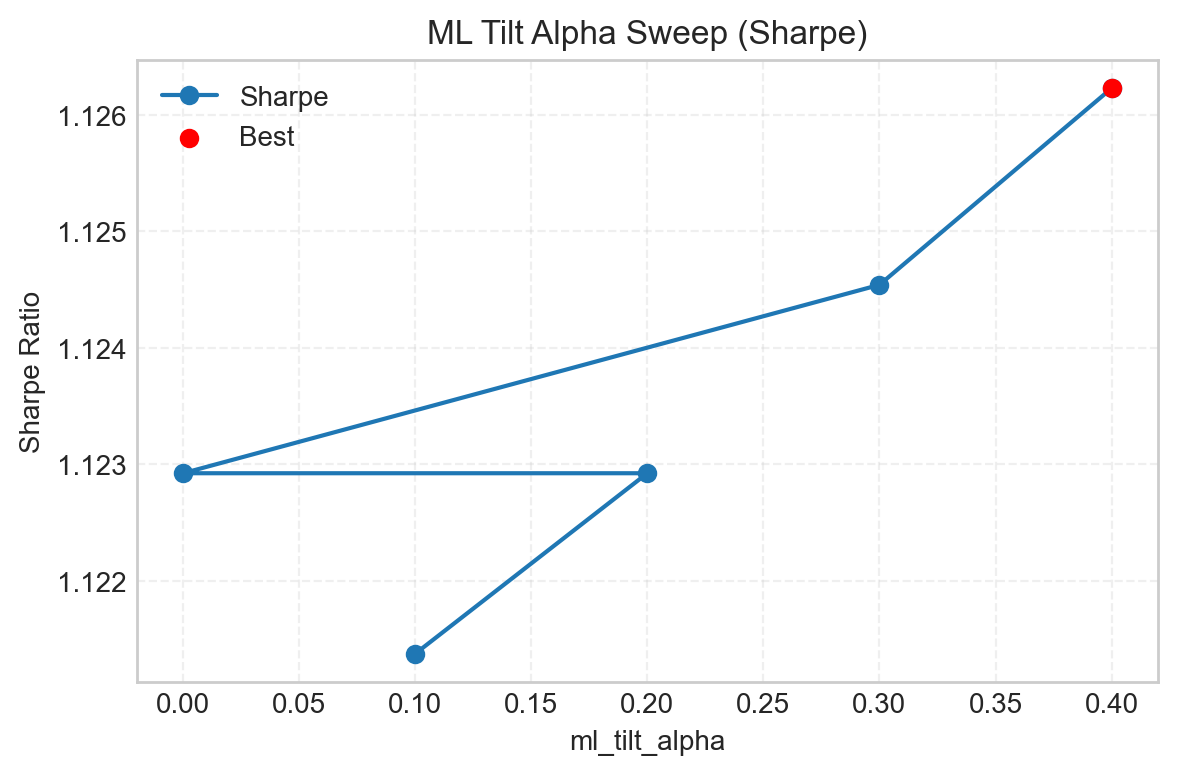

Saved plot to: examples\figures\ml_tilt_alpha_sweep.png


In [21]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from portfolio.backtesting.walk_forward import BacktestConfig, WalkForwardBacktester

# Ensure output dirs exist (in case this cell is run standalone)
if 'OUT_DIR' not in globals():
    OUT_DIR = os.path.join('examples', 'outputs')
    os.makedirs(OUT_DIR, exist_ok=True)
if 'FIG_DIR' not in globals():
    FIG_DIR = os.path.join('examples', 'figures')
    os.makedirs(FIG_DIR, exist_ok=True)

# Sweep alphas for the current backtest cadence (3y train / 2q test)
alphas = [0.0, 0.1, 0.2, 0.3, 0.4]
records = []
for a in alphas:
    cfg = BacktestConfig(train_years=3, test_quarters=2, include_ml_overlay=True, ml_tilt_alpha=a)
    bt = WalkForwardBacktester(cfg)
    res = bt.run_backtest(symbols, start_date, end_date)
    r = res.get('ml_overlay')
    if r is None or (getattr(r, 'metrics', None) is None):
        continue
    m = r.metrics
    records.append({
        'alpha': a,
        'sharpe': float(m.get('sharpe_ratio', 0.0)),
        'vol': float(m.get('annual_volatility', 0.0)),
        'ret': float(m.get('annual_return', 0.0)),
        'mdd': float(m.get('max_drawdown', 0.0)),
        'turnover': float(getattr(r, 'turnover', 0.0)),
        'tx_costs': float(getattr(r, 'transaction_costs', 0.0)),
    })

alpha_view = pd.DataFrame(records).sort_values(['sharpe', 'ret'], ascending=[False, False])
with pd.option_context('display.float_format', lambda x: f'{x:.4f}'):
    print(alpha_view.to_string(index=False))

# Save table + recommendation
alpha_csv = os.path.join(OUT_DIR, 'alpha_sweep.csv')
alpha_view.to_csv(alpha_csv, index=False, encoding='utf-8')
if not alpha_view.empty:
    pick = alpha_view.sort_values(['sharpe','ret','turnover'], ascending=[False, False, True]).iloc[0]
    msg = f"Recommended ml_tilt_alpha ≈ {pick['alpha']:.2f} (Sharpe={pick['sharpe']:.2f}, Vol={pick['vol']:.2f}, MDD={pick['mdd']:.2f})"
    print('\n' + msg)
    with open(os.path.join(OUT_DIR, 'alpha_sweep_recommendation.txt'), 'w', encoding='utf-8') as f:
        f.write(msg + '\n')
print(f'Saved alpha sweep to {alpha_csv}')

# Plot + save
if not alpha_view.empty:
    fig, ax = plt.subplots(figsize=(6,4))
    ax.plot(alpha_view['alpha'], alpha_view['sharpe'], marker='o', label='Sharpe')
    best_idx = alpha_view['sharpe'].idxmax()
    br = alpha_view.loc[best_idx]
    ax.scatter([br['alpha']], [br['sharpe']], color='red', zorder=5, label='Best')
    ax.set_xlabel('ml_tilt_alpha')
    ax.set_ylabel('Sharpe Ratio')
    ax.set_title('ML Tilt Alpha Sweep (Sharpe)')
    ax.grid(True, linestyle='--', alpha=0.3)
    ax.legend(loc='best')
    plt.tight_layout()
    display(fig)
    plot_path = os.path.join(FIG_DIR, 'ml_tilt_alpha_sweep.png')
    fig.savefig(plot_path, dpi=150)
    plt.show()
    print(f'Saved plot to: {plot_path}')

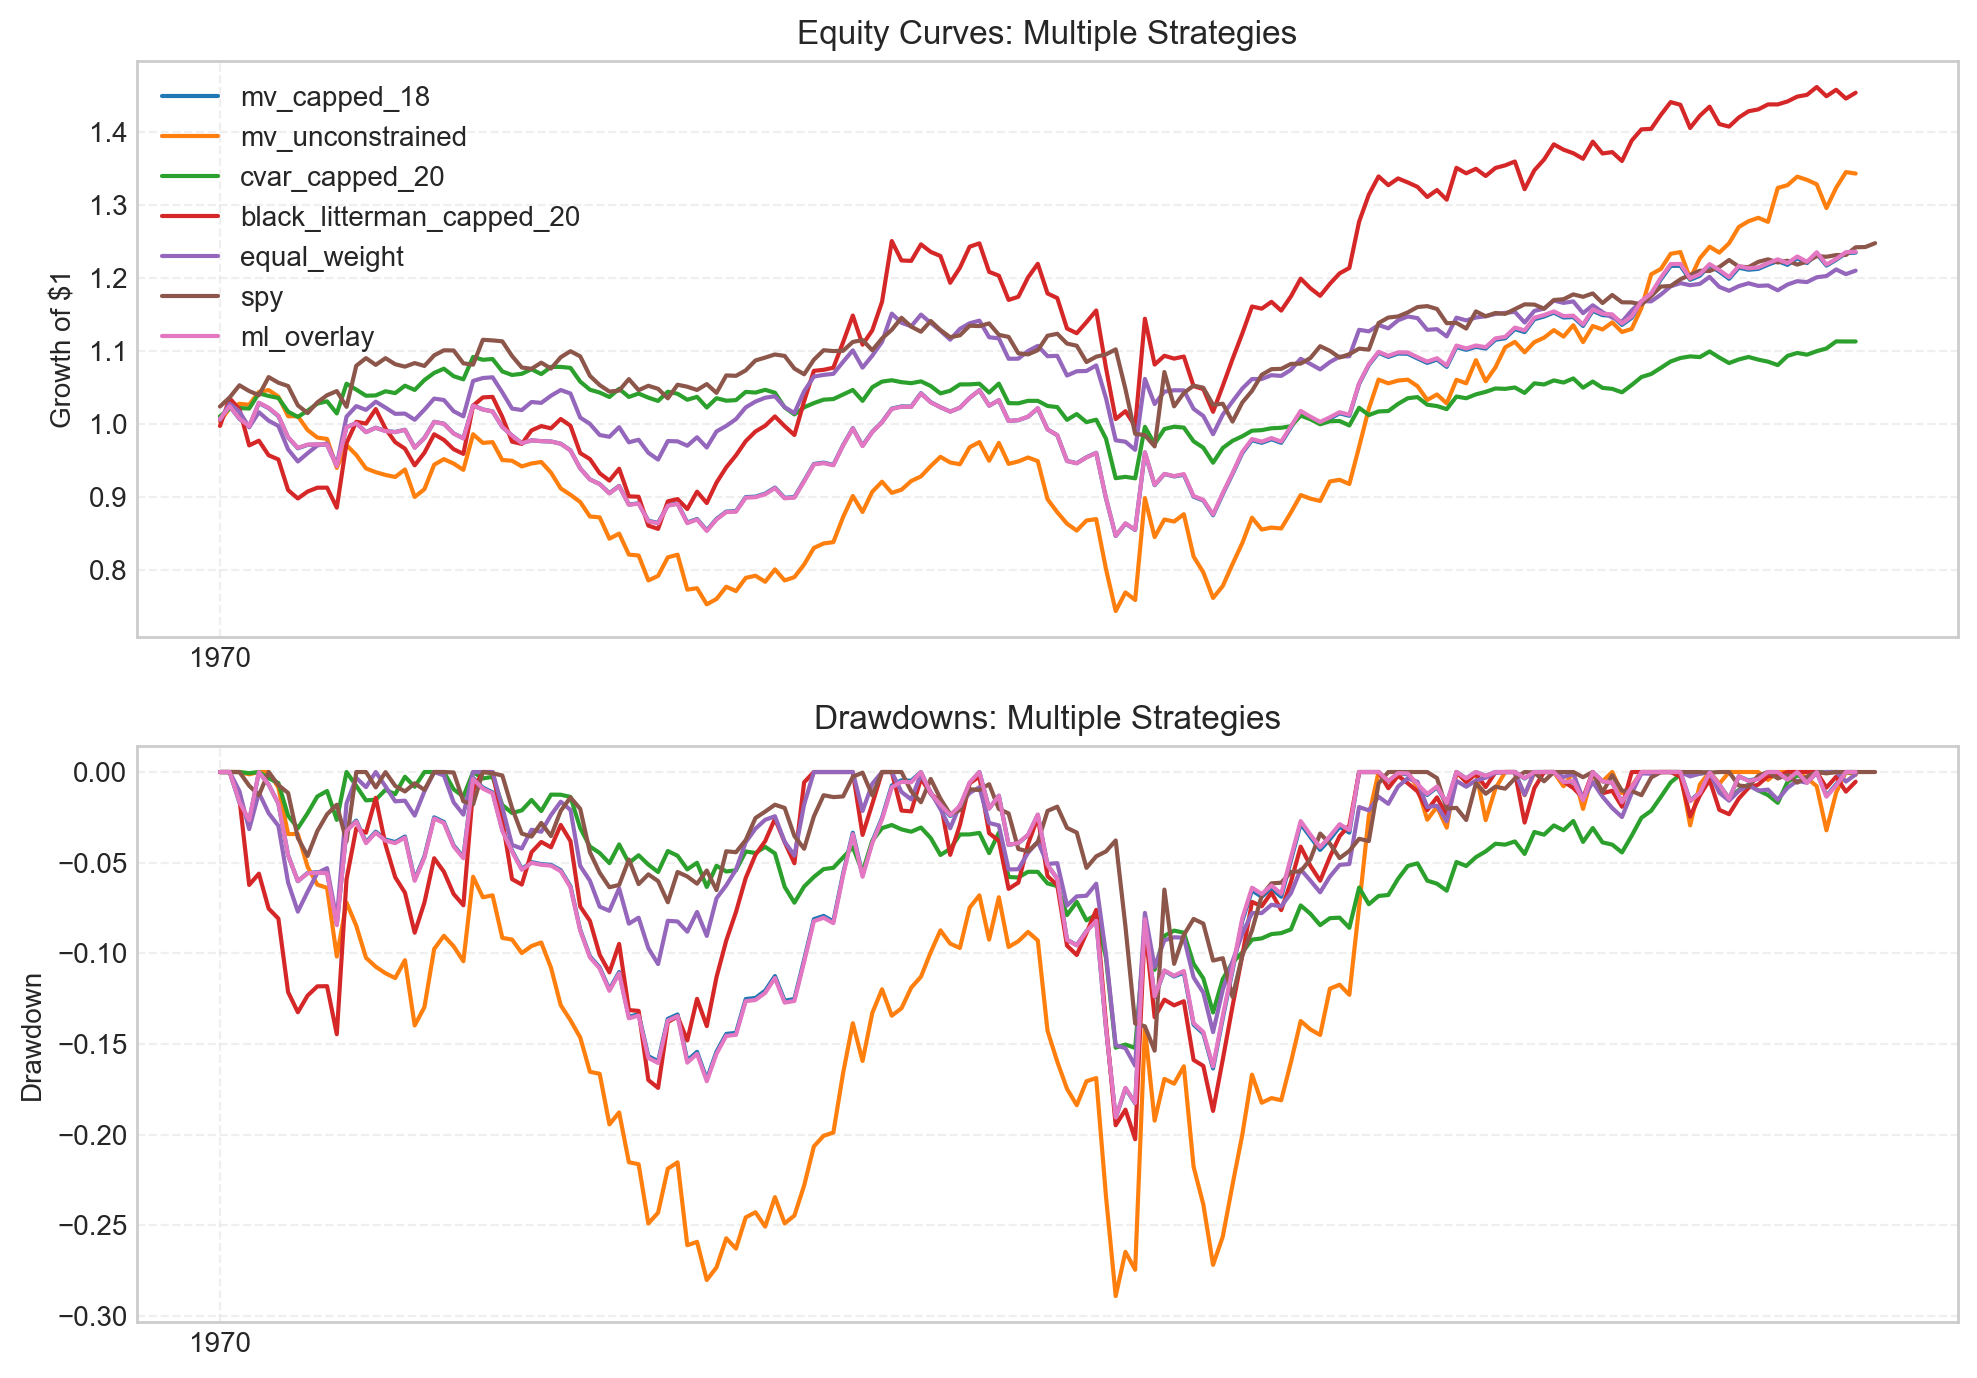

Saved multi-strategy plot to examples/figures/equity_drawdown_multistrategy.png


In [22]:
# Multi-strategy equity and drawdown plots (Strategy vs EW vs SPY)
from portfolio.performance.visualization import prepare_equity_curve, prepare_drawdown_curve

# Collect series from backtest results
# Reflect dynamic capped label based on config (e.g., mv_capped_18)
cap_label = f"mv_capped_{int(round(getattr(bt_cfg, 'max_position_cap', 0.18) * 100))}"
strategies_to_plot = [
    key for key in [
        cap_label, 'mv_unconstrained', 'cvar_capped_20', 'black_litterman_capped_20', 'equal_weight', 'spy', 'ml_overlay'
    ] if key in bt_results
]

fig, axes = plt.subplots(2, 1, figsize=(10, 7))

# Equity curves
for key in strategies_to_plot:
    r = bt_results[key].returns
    if r is None or r.empty:
        continue
    eq = prepare_equity_curve(r)
    axes[0].plot(eq.index, eq.values, label=key)
axes[0].set_title('Equity Curves: Multiple Strategies')
axes[0].set_ylabel('Growth of $1')
axes[0].legend(loc='best')
axes[0].grid(True, linestyle='--', alpha=0.3)

# Drawdowns (overlay)
for key in strategies_to_plot:
    r = bt_results[key].returns
    if r is None or r.empty:
        continue
    dd = prepare_drawdown_curve(r)
    axes[1].plot(dd.index, dd.values, label=key)
axes[1].set_title('Drawdowns: Multiple Strategies')
axes[1].set_ylabel('Drawdown')
axes[1].grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
from IPython.display import display
display(fig)
fig.savefig(os.path.join(FIG_DIR, 'equity_drawdown_multistrategy.png'), dpi=150)
print('Saved multi-strategy plot to examples/figures/equity_drawdown_multistrategy.png')

In [23]:
# Call API endpoints if server is up (demo)
import json, requests

BASE_URL = "http://127.0.0.1:8000"
try:
    r = requests.get(f"{BASE_URL}/health")
    if r.status_code == 200:
        print("API is reachable")
        # Optimize
        payload = {"symbols": symbols, "target_return": None}
        resp = requests.post(f"{BASE_URL}/optimize", json=payload, timeout=15)
        print("/optimize:", resp.status_code)
        print(list(resp.json().keys()))

        # Analyze
        payload = {"symbols": symbols}
        resp = requests.post(f"{BASE_URL}/analyze", json=payload, timeout=15)
        print("/analyze:", resp.status_code)
        print(list(resp.json().keys()))
    else:
        print("API not responding (status)")
except Exception as e:
    print("API not reachable:", e)


API not reachable: HTTPConnectionPool(host='127.0.0.1', port=8000): Max retries exceeded with url: /health (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x00000209E7412ED0>: Failed to establish a new connection: [WinError 10061] No connection could be made because the target machine actively refused it'))


In [ ]:
# Print results summary (robust)
try:
    results_df
except NameError:
    print("Please run the multi-symbol training cell first to create results_df.")
else:
    if results_df is None or results_df.empty:
        print("No results to summarize.")
    else:
        summary = {
            "symbols_trained": int(results_df.shape[0]),
            "avg_test_r2": float(results_df["test_r2"].mean()),
            "median_test_r2": float(results_df["test_r2"].median()),
            "avg_directional_accuracy": float(results_df["directional_accuracy"].mean()),
            "total_time_sec": float(results_df["sec"].sum()),
        }
        print("=== ML Training Summary ===")
        print(f"Symbols trained: {summary['symbols_trained']}")
        print(f"Average test R²: {summary['avg_test_r2']:.4f}")
        print(f"Median test R²: {summary['median_test_r2']:.4f}")
        print(f"Average directional accuracy: {summary['avg_directional_accuracy']:.1%}")
        print(f"Total training time: {summary['total_time_sec']:.2f} seconds")
        summary
